In [1]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Augmentations

- Horizontal flip -> In case of a left, right flip when scanning the X-ray
- Contrast -> For different X-ray quality
- Brightness -> For different X-ray quality
- Rotation -> In case of a shift while scanning the X-ray
- Vertical flip -> In case the image was not rotated with the correct side up
- Zoom -> In case the X-ray was targetted.

In [2]:
def augment(image):
    image = tf.image.random_contrast(image, 0.8, 1)
    image = tf.image.random_saturation(image, 0.8, 1)
    return image

In [3]:
image_size = 128
train_batch = ImageDataGenerator(
    horizontal_flip=True,
    brightness_range= (0.8, 1),
    rotation_range=10,
    vertical_flip=True,
    validation_split=0, 
    rescale = 1./255,
    zoom_range = (0.8, 1),
    preprocessing_function = augment
    ).flow_from_directory('train', target_size = (image_size, image_size), batch_size = 32, class_mode='binary')
val_batch = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    validation_split=0, 
    rescale=1./255,
    zoom_range = (0.8, 1),
    preprocessing_function = augment
    ).flow_from_directory('val', target_size = (image_size, image_size), batch_size = 32, class_mode='binary')

Found 4900 images belonging to 2 classes.
Found 631 images belonging to 2 classes.


## Compute Class Weights

In [4]:
# class weight = total/((nclass) * class)
normal = len(os.listdir('train/normal'))
tb = len(os.listdir('train/tb'))

total = normal + tb

normal_wt = total / (2 * normal)
tb_wt = total / (2 * tb)


cls_weight = {0:normal_wt, 1: tb_wt}
print('Class weights:', cls_weight)

Class weights: {0: 1.000204081632653, 1: 0.9997960016319869}


## Plot Images

Counter({0.0: 17, 1.0: 15})


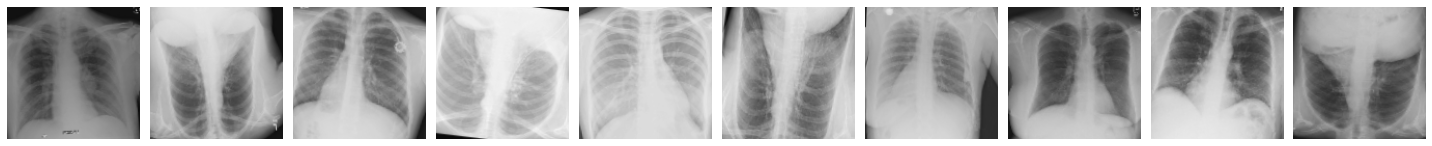

[0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]


In [5]:
def plot_images(images):
    
    fig, axes = plt.subplots(1,10, figsize = (20,20))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
imgs, labels = next(train_batch)
from collections import Counter

print(Counter(labels))
plot_images(imgs)
print(labels[0:10])

# Setup training parameters

In [6]:
learning_rate = 3e-4
batch_size = 32
num_epochs = 1000
classes = 1
patience = 15

In [7]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape= (image_size,image_size,3), include_top=False, weights='imagenet', classes=2
)


for layer in base_model.layers:
    layer.trainable = False
    
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [8]:
class weighted_loss(tf.keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__()
        self.weight = 2.0
    def call(self, y_true, y_pred):
        return tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, pos_weight = self.weight)

In [24]:
def get_model(base_model, loss = 'binary_crossentropy', units = 512):
    model = keras.Sequential()
    model.add(base_model)
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Flatten())
    
    for i in range(4):
        model.add(keras.layers.Dense(units))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.ReLU())
        model.add(keras.layers.Dropout(0.5))
        units = units//4

    model.add(keras.layers.Dense(classes, activation = 'sigmoid'))
    
    model.compile(loss = loss if isinstance(loss, str) else loss(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy'])
    model.summary()
    return model

# model = get_model(base_model)
# model = get_model(base_model, weighted_loss)

In [25]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1, 
mode='min'), 
            keras.callbacks.ModelCheckpoint(filepath='model.h5', verbose=1, monitor='val_loss', 
save_best_only=True, save_weights_only=False, mode='min')]

history = model.fit(
        train_batch,
#         epochs=num_epochs,
        epochs=5,
        steps_per_epoch = train_batch.n // batch_size,
        validation_data = val_batch,
        validation_steps = val_batch.n // batch_size,
        callbacks=callbacks,
#         class_weight = cls_weight
    )

Train for 153 steps, validate for 19 steps
Epoch 1/5
152/153 [============================>.] - ETA: 0s - loss: 0.5255 - accuracy: 0.7802 - binary_crossentropy: 0.5249
Epoch 00001: val_loss improved from inf to 0.67453, saving model to model.h5
153/153 [==============================] - 164s 1s/step - loss: 0.5250 - accuracy: 0.7808 - binary_crossentropy: 0.5244 - val_loss: 0.6745 - val_accuracy: 0.4951 - val_binary_crossentropy: 0.6745
Epoch 2/5
152/153 [============================>.] - ETA: 0s - loss: 0.4857 - accuracy: 0.8137 - binary_crossentropy: 0.4873
Epoch 00002: val_loss did not improve from 0.67453
153/153 [==============================] - 158s 1s/step - loss: 0.4857 - accuracy: 0.8131 - binary_crossentropy: 0.4873 - val_loss: 0.7245 - val_accuracy: 0.3816 - val_binary_crossentropy: 0.7245
Epoch 3/5
152/153 [============================>.] - ETA: 0s - loss: 0.4746 - accuracy: 0.8180 - binary_crossentropy: 0.4750
Epoch 00003: val_loss did not improve from 0.67453
153/153 [==

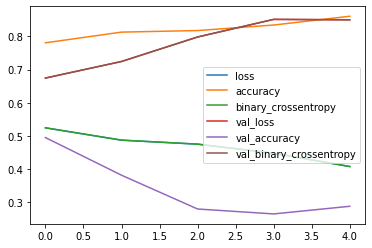

In [32]:
df = pd.DataFrame(history.history).plot()